## Model Evaluation Notebook

### Environment Setup

In [1]:
import sys
import os
sys.path
sys.path.append('..')
import pandas as pd
import numpy as np

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from pytorch_lightning import Trainer

from utils import MultiLabelImageDataset
from utils import EfficientNetMultiOutput_shared
from utils import evaluate_model

from utils import race_labels_FairFace
from utils import age_group_labels_Fairface

from utils import LimeImageDataset, lime_predict, find_misclassified_samples, visualize_misclassified_with_lime


import matplotlib.pyplot as plt

### Loading the Model for Evaluation  

In this section, we load the trained EfficientNet-based multi-output model from the saved checkpoint. This model will be used to predict gender, race, and age group on the validation and test datasets, which will later be used for performance evaluation and analysis.

In [2]:
checkpoint_path = "../models/CNN_EffNet_extended_unbalanced_higherLR_b128_gacc32_epoch=25-val_loss=2.16.ckpt"

model = EfficientNetMultiOutput_shared.load_from_checkpoint(checkpoint_path)
model.eval();

### Loading and preparing the Data

In [3]:
path_data = '../data/merged'
path_labels = '../data/merged/dataset_labels.csv'
df = pd.read_csv(path_labels)

In [4]:
train_df, remaining_df = train_test_split(df, test_size=0.30, random_state=42, stratify=df[['gender', 'race', 'age_group']])

val_df, test_df = train_test_split(remaining_df, test_size=0.5, random_state=42, stratify=remaining_df[['gender', 'race', 'age_group']])

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 70689
Validation set size: 15148
Test set size: 15148


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 64
test_dataset = MultiLabelImageDataset(test_df, path_data, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1, persistent_workers=True)

In [6]:
with torch.no_grad():
    for batch in test_loader:
        print(f"Batch contents: {len(batch)}")
        break

Batch contents: 4


### Model Evaluation

In this section, we evaluate the model's performance in predicting gender, race, and age group. For gender and race classification, we print key metrics such as accuracy, precision, recall, F1-score, and the confusion matrix. Additionally, ROC curves with corresponding AUC scores are plotted for each task to visualize the model's ability to distinguish between classes.


Gender Classification Metrics:
              precision    recall  f1-score   support

      Female       0.87      0.86      0.86      7826
        Male       0.85      0.86      0.86      7322

    accuracy                           0.86     15148
   macro avg       0.86      0.86      0.86     15148
weighted avg       0.86      0.86      0.86     15148



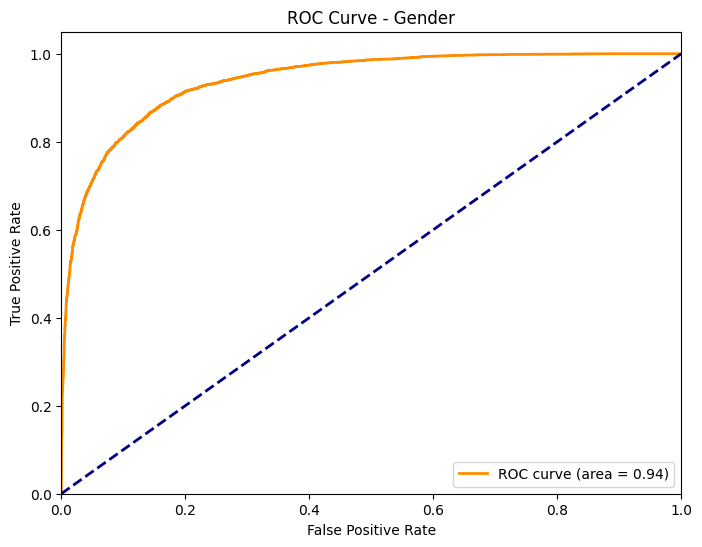


Race Classification Metrics:
                precision    recall  f1-score   support

    East Asian       0.74      0.68      0.71      3635
        Indian       0.76      0.76      0.76      2300
         Black       0.76      0.75      0.76      3723
         White       0.60      0.65      0.63      2240
Middle Eastern       0.52      0.55      0.54      3250

      accuracy                           0.68     15148
     macro avg       0.68      0.68      0.68     15148
  weighted avg       0.68      0.68      0.68     15148



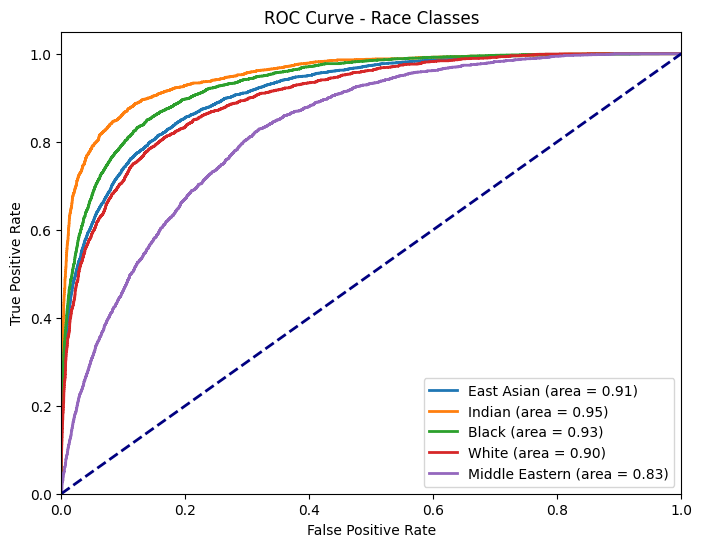


Age Group Classification Metrics:
              precision    recall  f1-score   support

         0-2       0.59      0.75      0.66       399
         3-9       0.75      0.44      0.56      1672
       10-19       0.32      0.29      0.30      1509
       20-29       0.54      0.63      0.58      4568
       30-39       0.38      0.46      0.41      3210
       40-49       0.32      0.32      0.32      1745
       50-59       0.41      0.28      0.33      1169
       60-69       0.37      0.26      0.31       554
         70+       0.71      0.39      0.51       322

    accuracy                           0.46     15148
   macro avg       0.49      0.42      0.44     15148
weighted avg       0.47      0.46      0.46     15148



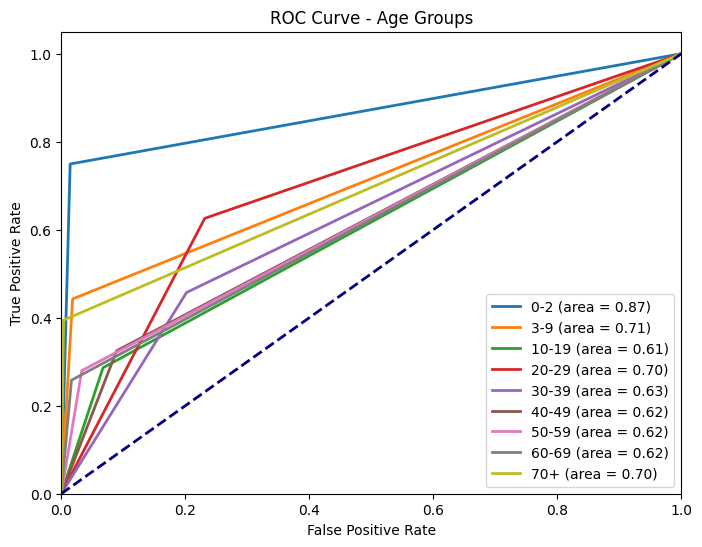

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

evaluate_model(model, test_loader, device)

**Gender Classification**

The model achieved an accuracy of 86% for gender classification, with precision, recall, and F1-scores all balanced at 0.86 for both male and female classes. The ROC curve shows an AUC of 0.94, indicating strong discriminatory ability between the two classes. Overall, the model performs robustly for gender prediction, showing high sensitivity and specificity.

**Race Classification**

The model attained an overall accuracy of 68% for race classification. Class-wise performance indicates that the model performs best on the Indian (F1-score: 0.76, AUC: 0.95) and Black (F1-score: 0.76, AUC: 0.93) classes. The Middle Eastern class showed the lowest performance (F1-score: 0.54, AUC: 0.83), highlighting a potential imbalance or feature overlap issue. The ROC curves for race classes exhibit decent separation, but further improvements may be needed for underperforming classes.

**Age Group Classification**

Age group prediction proved the most challenging, with an overall accuracy of 46% and a weighted F1-score of 0.46. The ROC curve shows varying AUC scores across age groups, with the 0-2 age group achieving the highest AUC (0.87) and performance declining for older groups (AUC around 0.61–0.70 for most). The performance drop for middle and older age groups suggests the need for additional data or advanced modeling strategies for these segments.

**Conclusion**

The model demonstrates solid performance in gender classification and moderate success in race classification but struggles with age group predictions, especially in older categories. To improve performance, targeted data augmentation for underrepresented classes, advanced loss functions for ordinal age prediction, or further hyperparameter tuning could be beneficial.


### Model Interpretability with LIME

To better understand where the model is struggling, we will use LIME (Local Interpretable Model-Agnostic Explanations). LIME helps explain the predictions of complex models by approximating them locally with interpretable models. By highlighting the most influential regions of input images for each prediction, LIME allows us to pinpoint areas where the model may be misclassifying gender, race, or age groups.


Gender Misclassifications:


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

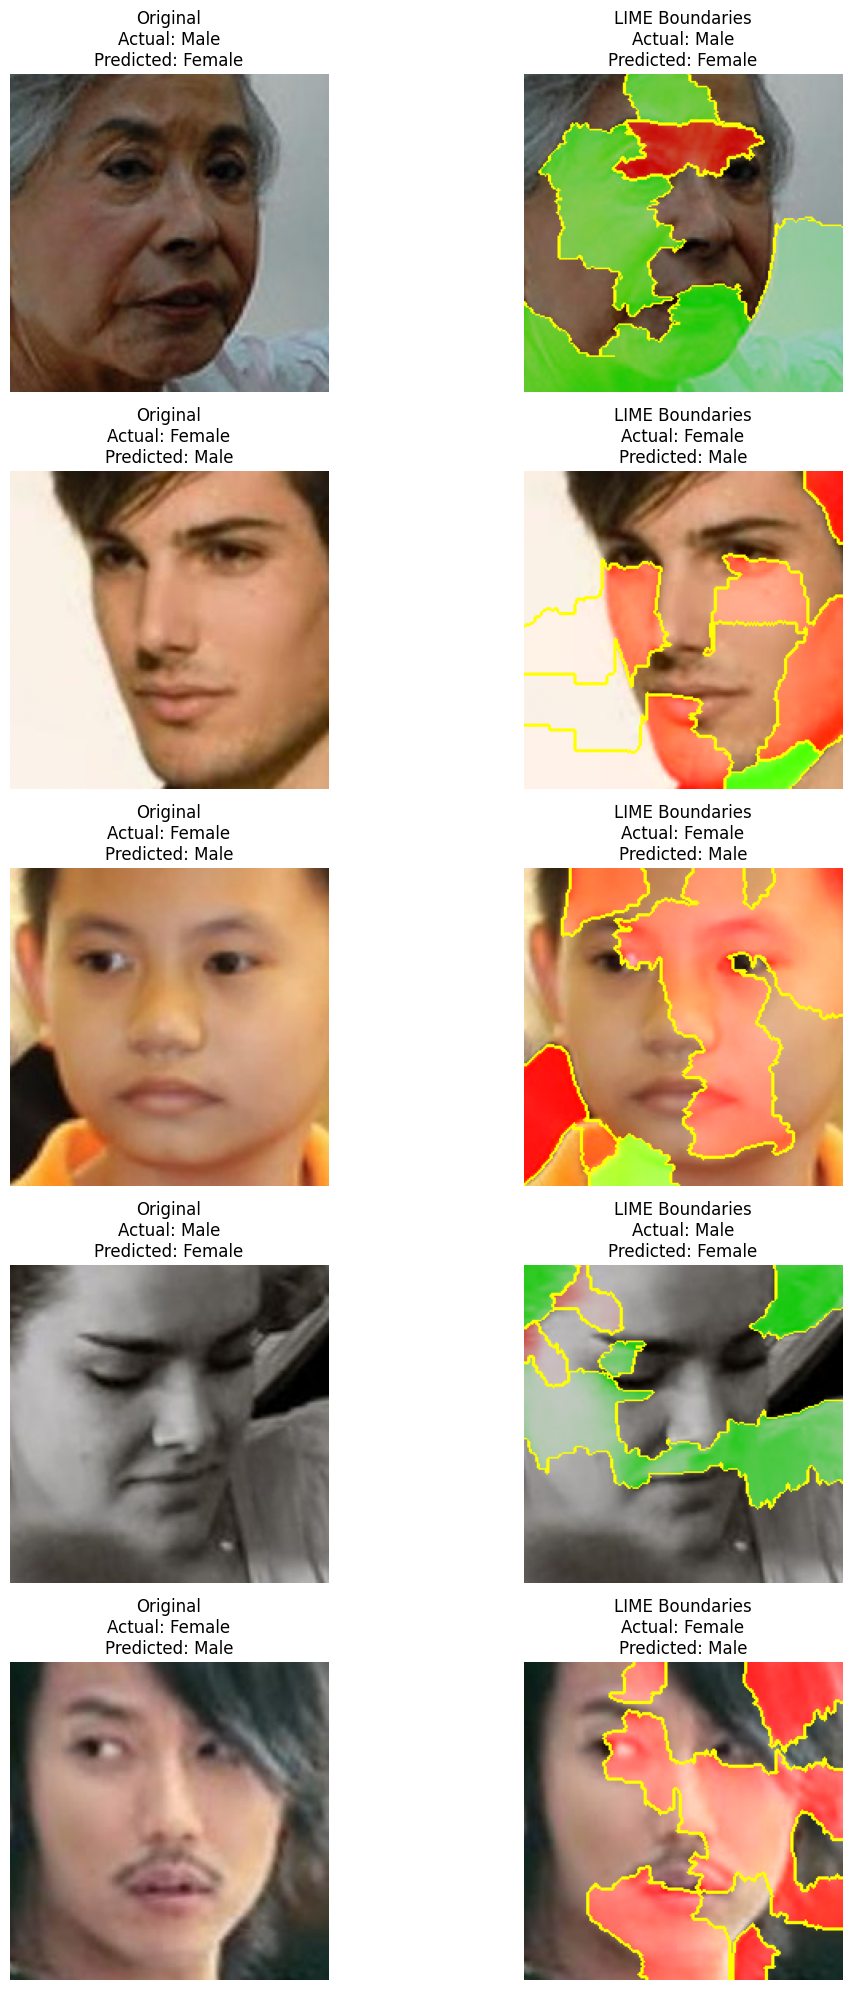

In [8]:
print("\nGender Misclassifications:")
gender_labels = ["Female", "Male"]
visualize_misclassified_with_lime(
    model, LimeImageDataset(test_df, path_data), device, "gender", gender_labels
)

**Gender Classification**

The model shows promising results in gender classification, with LIME confirming that it learns and relies on meaningful facial features. However, misclassifications are partly influenced by label noise and ambiguous examples within the dataset. To further improve performance, future work should focus on refining the dataset by correcting mislabeled instances and potentially introducing additional preprocessing steps to enhance feature clarity. Additionally, incorporating techniques to reduce model reliance on non-informative regions could help improve overall prediction accuracy.


Race Misclassifications:


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

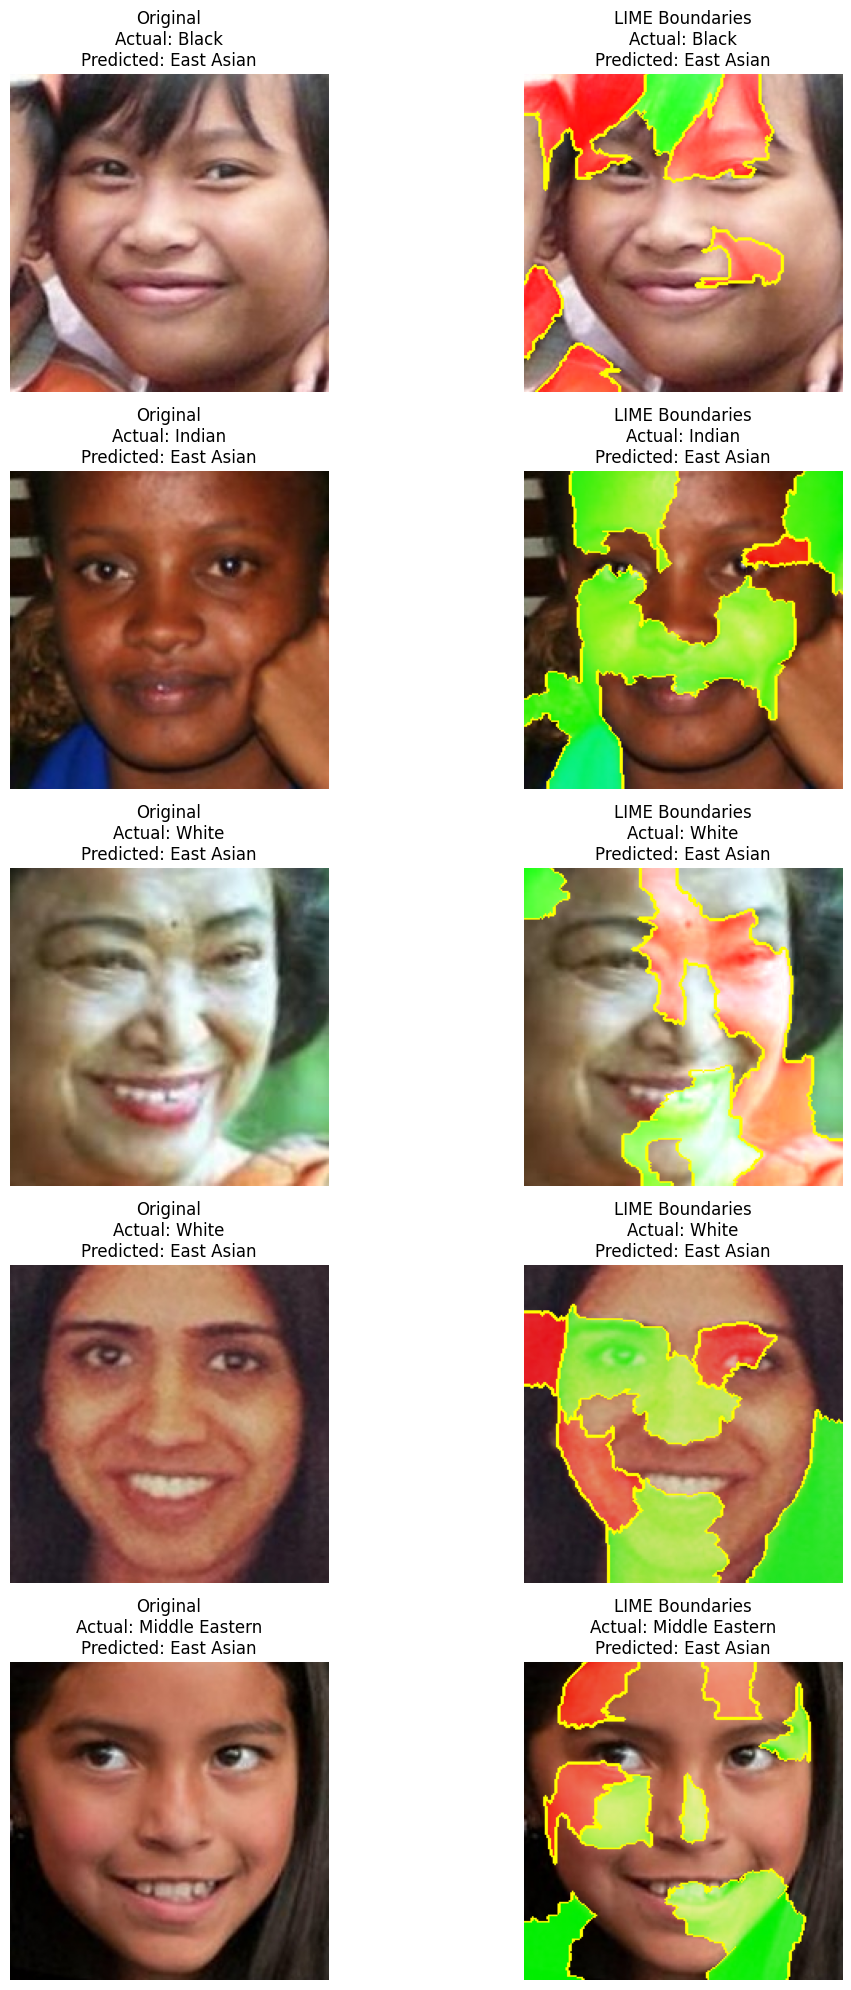

In [9]:
print("\nRace Misclassifications:")
race_labels = list(race_labels_FairFace.values())
visualize_misclassified_with_lime(
    model, LimeImageDataset(test_df, path_data), device, "race", race_labels
)

**Race Classification** 

While the model demonstrates the ability to focus on relevant facial features for race classification, repeated misclassifications—especially towards the East Asian category—highlight potential biases and data imbalance issues. To enhance model performance, it is essential to refine the dataset by correcting mislabeled instances, balancing race class distributions, and potentially introducing region-specific attention mechanisms. Reducing model reliance on non-informative areas through improved preprocessing or model regularization could also contribute to better generalization and accuracy.


Age Group Misclassifications:


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

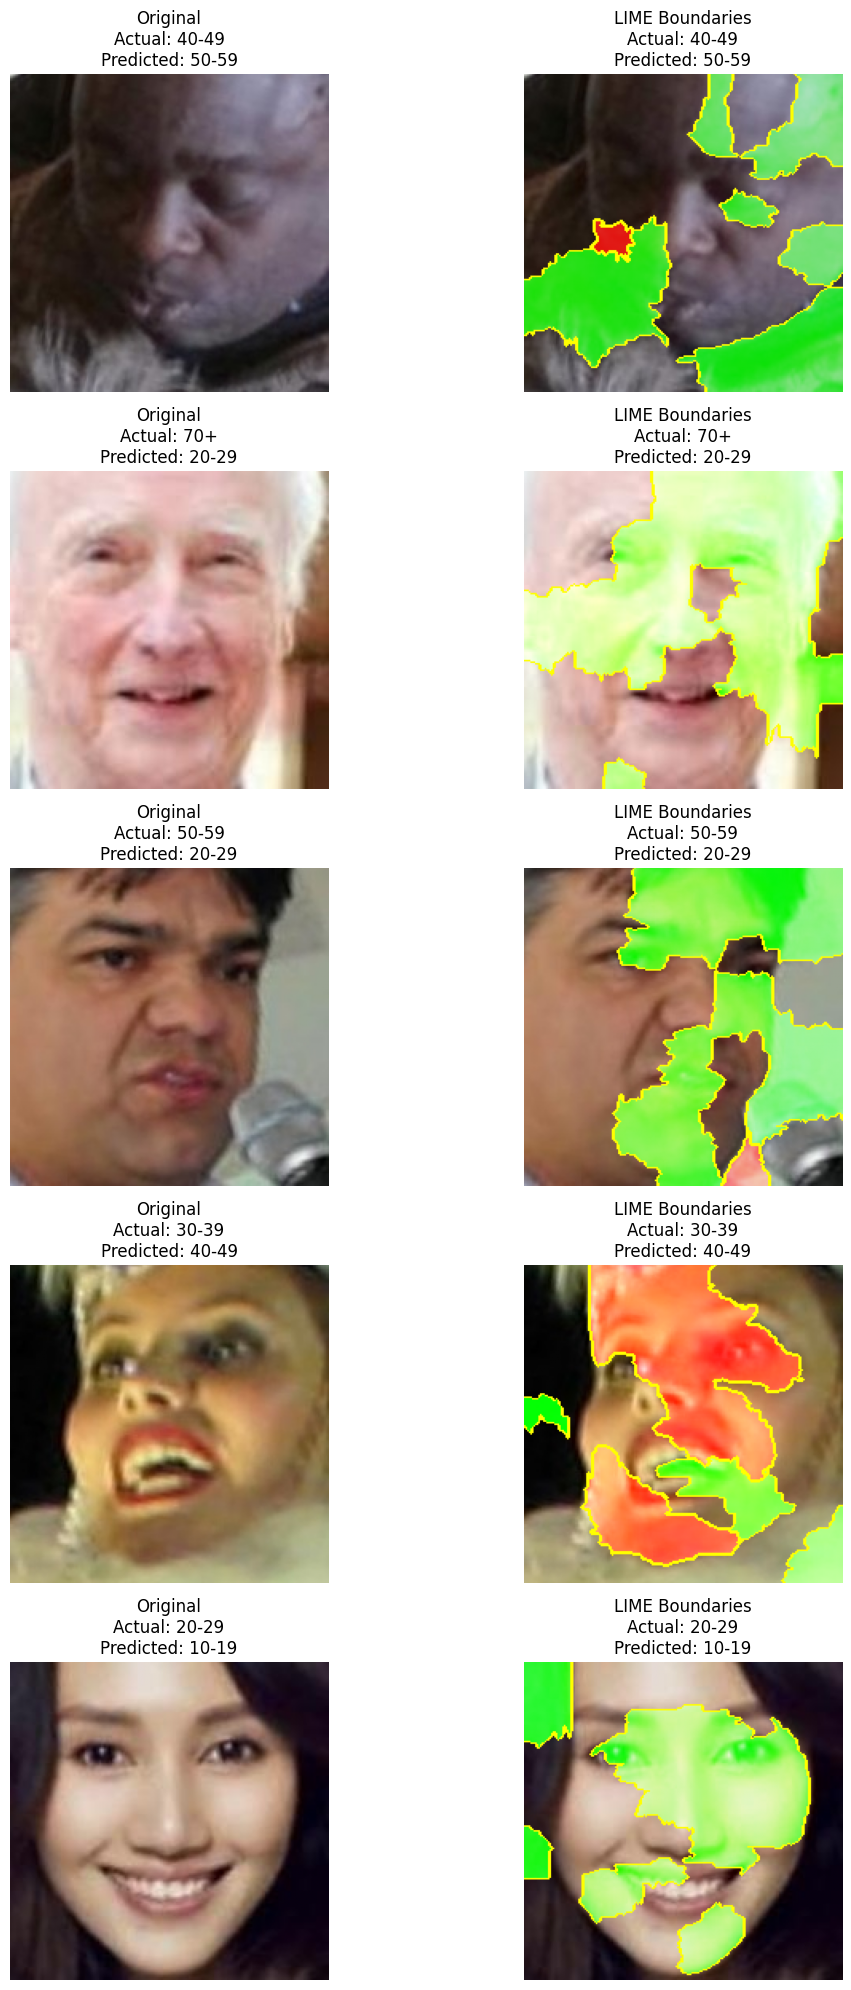

In [10]:
print("\nAge Group Misclassifications:")
age_labels = list(age_group_labels_Fairface.values())
visualize_misclassified_with_lime(
    model, LimeImageDataset(test_df, path_data), device, "age", age_labels
)

**Age Classification**

The model captures age-related features but struggles with boundary confusion between adjacent age groups. This suggests a need for better handling of ordinal relationships in the data. Future improvements could include:

* Ordinal loss functions to better reflect the progressive nature of age.
* Additional training data for underrepresented age groups, especially older individuals.
* Data augmentation techniques that emphasize age-related changes (e.g., synthetic aging effects).
* Fine-tuning feature extraction to focus on more robust age-related facial cues rather than ambiguous regions.

By addressing these challenges, the model's age classification accuracy can be significantly improved, reducing misclassification errors across age groups.